# CSE 482 Class Project

**Student Name**: Mounika Jetti  
**Topic**: Development of a recommender system Web site

## Movie Recommendation System

Modern tech and retail companies make extensive use of intricate recommendation systems to enhance customer experience. 

- 35% of Amazon's revenue is generated by it's recommendation system ([source](https://www.rejoiner.com/resources/amazon-recommendations-secret-selling-online)).
- For Netflix, 80% of movies that people watch are based on some sort of recommendation ([source](https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48)).

The objective of a recommendation system is to tailor the experience of a service to suit the taste of a particular customer. This becomes even more relevant with online video content services like Netflix and Youtube with colossal digital libraries. For example, Youtube would offer a particular individual a unique view to its vast library personalized based on geography, language, etc.

Our objective is to design a robust movie recommendation system using ratings data available at [MovieLens website](https://movielens.org/). 

| ![Movielens Banner](images/movie-banner.jpg) |
|:--:|
| <b>Fig.1 - MovieLens Banner (Source: [paperswithcode](https://paperswithcode.com/dataset/movielens))</b>|

MovieLens is a  non-commercial system that utilizes movie ratings given by a particular user to build a custom taste profile for a user. This profile is then used to make intelligent movies recommendations for the user to watch.

While we are only going to use the rating dataset from this website, our final goal is to build something on similar lines.  

We will build a variety of recommendation engines and improve upon predictions iteratively so that the end user can be provided with better movie suggestions.

## Libraries

In [1]:
# basic libraries
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS # wordclouds

# for interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display, clear_output

# surprise library for recommendation engines
# used for collaborative engines
from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# warning surpress
import warnings
warnings.filterwarnings('ignore')

## Data Exploration and Visualization

We will use the benchmark [MovieLens 25M dataset](https://grouplens.org/datasets/movielens/). We might choose to use a small sample of the dataset for some experiments as it was difficult to run collaborative filtering techniques on the full version.

The dataset contains 25 million ratings and one million tag applications across 62,000 movies. These data points were created by 162,000 users.

The datasets describe ratings and free-text tagging activities from [MovieLens](http://movielens.org), a movie recommendation service.

> Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>


The dataset is distributed among four csv files: `links.csv`, `movies.csv`, `ratings.csv`, `tags.csv`.


Let's now look at each of these 4 files separately. 

### Tags Data

Information regarding tags is contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

    userId,movieId,tag,timestamp

* `userId`: Unique id for each user
* `movieId`: Unique id for each movie
* `tag`: User-generated metadata about the movie in forms of short meaningful phrases
* `timestamp`: Time when tag was provided by user


In [2]:
# Basic Stats - tags data
tags_data = pd.read_csv("data/ml-25m/tags.csv")

print("All columns in tags data: ", list(tags_data.columns))
print('Tag data size:', tags_data.shape)

print('\nInfo about each column:\n')
print(tags_data.info())

print('\nFirst few rows:')
tags_data.head()

All columns in tags data:  ['userId', 'movieId', 'tag', 'timestamp']
Tag data size: (1093360, 4)

Info about each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
None

First few rows:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


We are not planning to use timestamp information. So we will drop that column.

In [3]:
tags_data = tags_data.drop(columns=['timestamp'])

In [4]:
tags_data.head()

,userId,movieId,tag
0,3,260,classic
1,3,260,sci-fi
2,4,1732,dark comedy
3,4,1732,great dialogue
4,4,7569,so bad it's good


In [5]:
# Checking for null values
tags_data.isnull().sum()

userId      0
movieId     0
tag        16
dtype: int64

There are some rows with empty tag values. We will drop these rows from the dataset.

In [6]:
tags_data = tags_data.dropna()
tags_data.isnull().sum()

userId     0
movieId    0
tag        0
dtype: int64

Tags seem to provide us a little bit insight about how the user felt about the movie. 

We can analyze these tags using NLP to further understand the overall sentiment about the movie. Let's try looking at these tags as a wordcloud and see if some words are more repetitive than others.

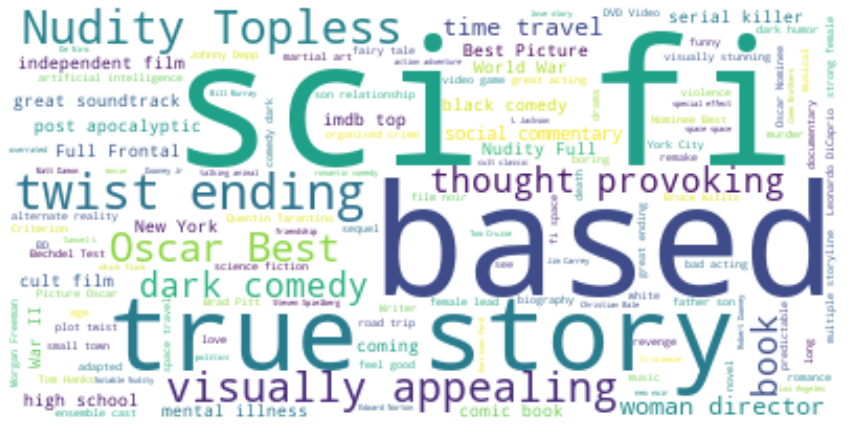

In [7]:
all_tags = " ".join(i for i in tags_data.tag)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(all_tags)

# Display the generated image:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looking at the top 15 most popular tags in our dataset.

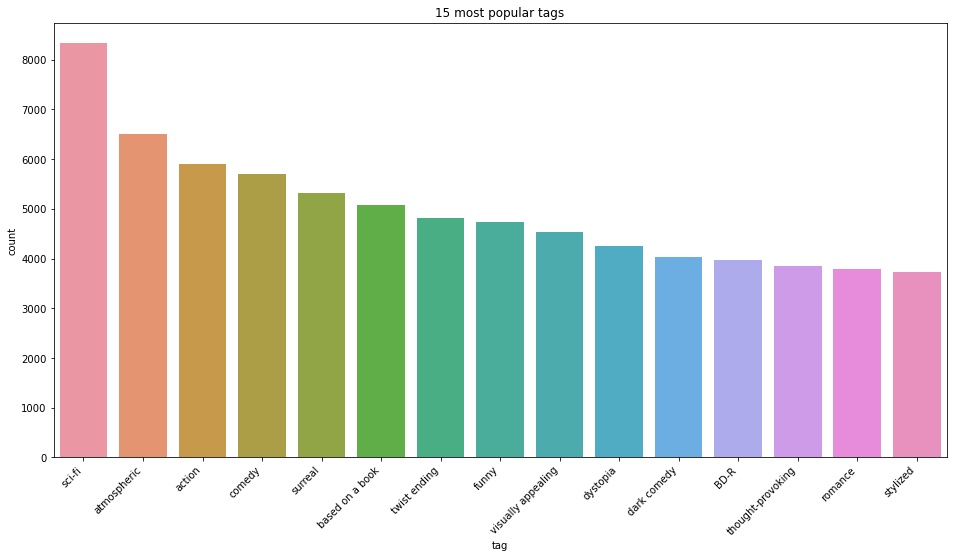

In [8]:
plt.figure(figsize=(16,8))
sns.countplot(tags_data['tag'],order=tags_data['tag'].value_counts().iloc[:15].index)
plt.title('15 most popular tags')
plt.xticks(rotation=45, ha='right')
#plt.savefig('tags_count.png')
plt.show()

While I do believe that there is useful information available in tags data, I think utilizing it will require incorporating advanced NLP techniques which currently is outside the scope of this project. But will definitely revisit this in future iterations.

### Movies Data

`movies.csv` file contains details about the movies. Each line of this file represents one movie, and has the following format:

    movieId,title,genres

- `movieId`: Unique id for each movie
- `title`: Name of movies followed by their year of release
- `genres`: categories that a movie might fall into separated by `|`


In [9]:
# Basic stats - movies data
movies_data = pd.read_csv("data/ml-25m/movies.csv")

print("All columns in movies data: ", list(movies_data.columns))
print('Movies data Size:', movies_data.shape)

print('\nInfo about each column:\n')
print(movies_data.info())

print('\nFirst few rows:')
movies_data.head()

All columns in movies data:  ['movieId', 'title', 'genres']
Movies data Size: (62423, 3)

Info about each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None

First few rows:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The `tile` column has the release year for the movie concatenated with the movie title. So, to utilize that information some preprocessing will be required. 

Also, all genres are concatenated together in a string separated by `|`. We will need to separate each genre into its own column to use that information in a meaningful way. 

In [10]:
# Checking for null values
movies_data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Thankfully, there is no null values in the dataset so we don't need to think about how to handle them. So let's now deal with the release year.

In [11]:
# Extracting release year from movie title
# regex will pick things between round brackets
movies_data['year'] = movies_data['title'].str.extract('.*\((.*)\).*',expand = False)

In [12]:
# prints all unique values in year column
movies_data['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1988', '1967', '1993',
       '1964', '1977', '1965', '1982', '1990', '1991', '1989', '1937',
       '1940', '1969', '1981', '1973', '1970', '1960', '1955', '1959',
       '1968', '1980', '1975', '1986', '1948', '1943', '1950', '1946',
       '1987', '1997', '1974', '1956', '1958', '1949', '1972', '1998',
       '1933', '1952', '1951', '1957', '1961', '1954', '1934', '1944',
       '1963', '1942', '1941', '1953', '1939', '1947', '1945', '1938',
       '1935', '1936', '1926', '1932', '1985', '1979', '1971', '1978',
       '1966', '1962', '1983', '1984', '1931', '1922', '1999', '1927',
       '1929', '1930', '1928', '1925', '1914', '2000', '1919', '1923',
       '1920', '1918', '1921', '2001', '1924', '2002', '2003', '1915',
       '2004', '1916', '1917', '2005', '2006', '1902', '1903', '2007',
       '2008', '2009', '1912', '2010', 'Das Millionenspiel', '1913',
       '2011', '1898', '1899', '1894', '2012', '1910', '2013', '1983)',
       

The filter did a pretty good job with a couple of exceptions. There is '2006–2007', 'Your Past Is Showing', 'Das Millionenspiel', 'Close Relations', '1983)', and nan. Let's take a closer look at the movies they correspond to:

In [13]:
movies_data[movies_data['year'] == "2006–2007"]

,movieId,title,genres,year
46097,171749,Death Note: Desu nôto (2006–2007),(no genres listed),2006–2007


In [14]:
# After checking on the internet, we decided to change this to 2007
movies_data['year'] = movies_data['year'].replace("2006–2007","2007")

In [15]:
movies_data[movies_data['year'] == "Your Past Is Showing"]

,movieId,title,genres,year
32741,141628,The Naked Truth (1957) (Your Past Is Showing),Comedy,Your Past Is Showing


In [16]:
# Changing this to 1957
movies_data['year'] = movies_data['year'].replace("Your Past Is Showing","1957")

In [17]:
movies_data[movies_data['year'] == "Das Millionenspiel"]

,movieId,title,genres,year
15036,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,Das Millionenspiel


In [18]:
# After checking on the internet, we decided to change this to 1970
movies_data['year'] = movies_data['year'].replace("Das Millionenspiel","1970")

In [19]:
movies_data[movies_data['year'] == "Close Relations"]

,movieId,title,genres,year
43350,165821,Rodnye (Close Relations),Documentary,Close Relations


In [20]:
# After checking on the internet, we decided to change this to 2016
movies_data['year'] = movies_data['year'].replace("Close Relations","2016")

In [21]:
movies_data[movies_data['year'] == "1983)"]

,movieId,title,genres,year
18789,98063,Mona and the Time of Burning Love (Mona ja pal...,Drama,1983)


In [22]:
# Fixing it to 1983
movies_data['year'] = movies_data['year'].replace("1983)","1983")

In [23]:
# movies with no year information
movies_data[pd.isna(movies_data['year'])]

,movieId,title,genres,year
25387,123619,Terrible Joe Moran,(no genres listed),NaN
26284,125571,The Court-Martial of Jackie Robinson,(no genres listed),NaN
26309,125632,In Our Garden,(no genres listed),NaN
26392,125958,Stephen Fry In America - New World,(no genres listed),NaN
26576,126438,Two: The Story of Roman & Nyro,Documentary|Drama,NaN
...,...,...,...,...
62071,207714,Tales of Found Footage,(no genres listed),NaN
62104,207884,Enduring Destiny,(no genres listed),NaN
62285,208597,Punk the Capital: Building a Sound Movement,Documentary,NaN
62326,208763,Yosemite: The Fate of Heaven,(no genres listed),NaN


In [24]:
# As many of these don't have any genres as well, we will drop these rows
movies_data = movies_data.dropna(subset=['year'],how='any')
movies_data['year'] = movies_data['year'].astype(int)

In [25]:
print('We have movies in our dataset starting from year',movies_data['year'].min(),'and the latest movie is from the year',movies_data['year'].max())

We have movies in our dataset starting from year 1874 and the latest movie is from the year 2019


In [26]:
movies_data['year'].value_counts()

2015    2513
2016    2489
2014    2406
2017    2374
2013    2173
        ... 
1883       1
1887       1
1874       1
1878       1
1880       1
Name: year, Length: 135, dtype: int64

<AxesSubplot:xlabel='year', ylabel='Count'>

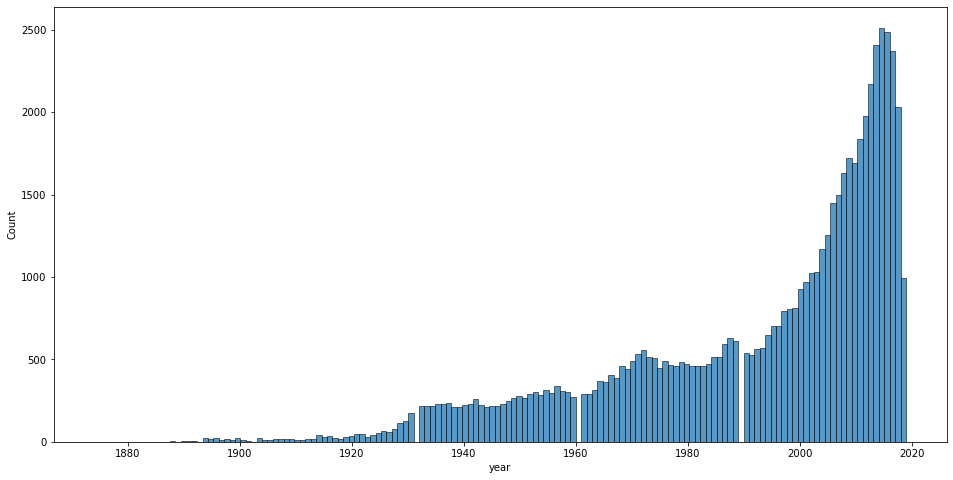

In [35]:
plt.figure(figsize=(16,8))
sns.histplot(movies_data['year'],bins=150)
#plt.savefig('year_count.png')

The graph shows that the number of movies released every year keeps on increasing with 2015 being the year with the highest number of releases at 2513 !!!

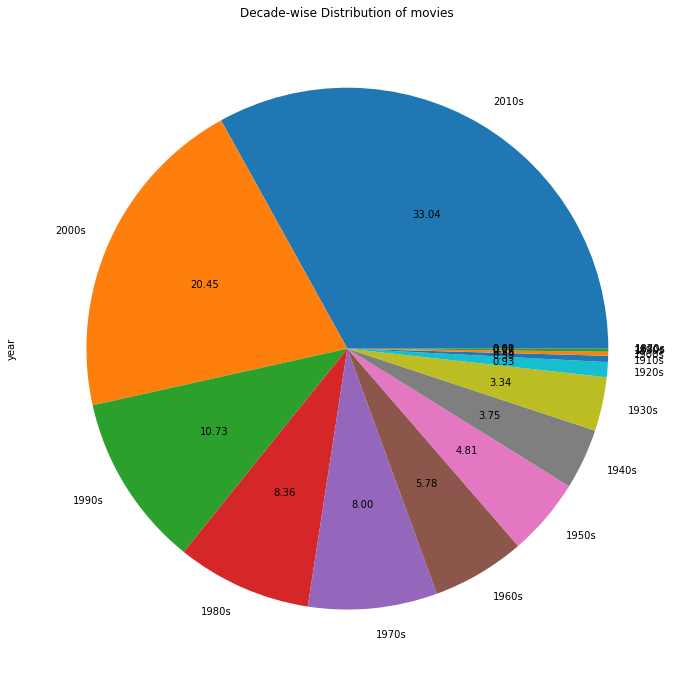

In [36]:
# Plotting decade-wise distribution of movies
plt.figure(figsize=(16,12))
movies_decade_data = movies_data["year"].apply(lambda x:str(int(x)//10*10)+'s')
movies_decade_data.value_counts().plot.pie(title='Decade-wise Distribution of movies', autopct="%.2f")
plt.show()

As expected, movies from 2000s and 2010s are going to dominate our dataset. This might add some bias in our engine towards movies from these 2 decades.

### Links Data

The file `links.csv` contains indentifiers that can be used to link this data to other data sources like IMDb. Each line of this file after the header row represents one imdb link, and has the following format:

    movieId,imdbId,tmdbId

* `movieId`: Unique id for each movie as used by https://movielens.org.
* `imdbId`: Unique id for each movie as used by http://www.imdb.com. 
* `tmdbId`: Unique id for each movie as used by https://www.themoviedb.org.


In [37]:
# Basic Stats - Link Data
links_data = pd.read_csv("data/ml-25m/links.csv")

print("All columns in links data: ", list(links_data.columns))
print('Links data size:', links_data.shape)

print('\nInfo about each column:\n')
links_data.info()

print('\nFirst few rows:')
links_data.head()

All columns in links data:  ['movieId', 'imdbId', 'tmdbId']
Links data size: (62423, 3)

Info about each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB

First few rows:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


This table can be used to extract more information about a particular movie. For example, we can use this table to get details like cast, director, etc. This is currently outside the scope of this project and will be used in a future iteration.

### Ratings Data

Ratings information is contained in the file `ratings.csv`. Each line of this file after the header row represents one rating, and has the following format:

    userId,movieId,rating,timestamp

* `userId`: Unique id for each user
* `movieId`: Unique id for each movie
* `rating`: Rating given by `userId` for `movieId`. Ratings are made on a 5-star scale with 0.5 increments. 
* `timestamp`: Time when rating was given

In [38]:
# Basic Stats - Ratings data
ratings_data = pd.read_csv("data/ml-25m/ratings.csv")

print("All columns in ratings data: ", list(ratings_data.columns))
print('Ratings data size:', ratings_data.shape)

print('\nInfo about each column:\n')
ratings_data.info()

print('\nFirst few rows:')
ratings_data.head()

All columns in ratings data:  ['userId', 'movieId', 'rating', 'timestamp']
Ratings data size: (25000095, 4)

Info about each column:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB

First few rows:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We are not planning to use timestamp information. So we will drop that column.


In [39]:
ratings_data = ratings_data.drop(columns=['timestamp'])
ratings_data.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [40]:
# Checking for null values
ratings_data.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

So no null values here. Now, let's look a little bit deeper into ratings.

In [41]:
ratings_data['rating'].describe().round(2)

count    25000095.00
mean            3.53
std             1.06
min             0.50
25%             3.00
50%             3.50
75%             4.00
max             5.00
Name: rating, dtype: float64

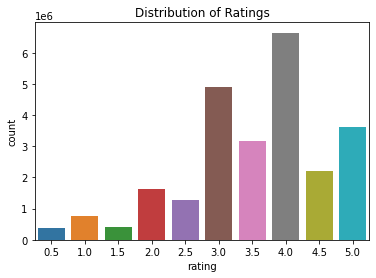

In [42]:
sns.countplot(ratings_data['rating'])
plt.title('Distribution of Ratings')
#plt.savefig('rating_count.png')
plt.show()

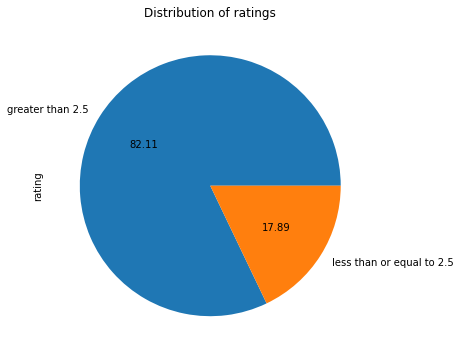

In [43]:
# Plotting distribution of ratings
plt.figure(figsize=(10,6))
ratings_greater_than_half = ratings_data['rating'].apply(lambda x: "greater than 2.5" if x>2.5 else "less than or equal to 2.5")
ratings_greater_than_half.value_counts().plot.pie(title='Distribution of ratings', autopct="%.2f")
plt.show()

So, the ratings go from `0.5 - 5` and we observe that the ratings are usually very generous. The mean rating given by users is approximately `3.5`. `4` is the most common rating in the dataset. 82% of the ratings in the dataset are above `2.5`.

While looking at some parts of the data, I noticed some duplicate values in movie titles. Let's check.

In [44]:
# Validation check
print('Is there a duplicate value in a column movieId? Ans:',not movies_data["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies_data["title"].is_unique)

movies_data[movies_data.duplicated(["title"], keep=False)]

Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: True


,movieId,title,genres,year
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,1992
1710,1788,Men with Guns (1997),Action|Drama,1997
2553,2644,Dracula (1931),Horror,1931
2759,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,1980
3454,3553,Gossip (2000),Drama|Thriller,2000
...,...,...,...,...
61525,206125,Lost & Found (2018),Comedy|Drama,2018
61697,206674,Camino (2016),Comedy,2016
61714,206712,American Woman (2019),(no genres listed),2019
61800,206925,The Plague (2006),Documentary,2006


In [45]:
movies_data[movies_data['title']=='Dracula (1931)']

,movieId,title,genres,year
2553,2644,Dracula (1931),Horror,1931
50069,180205,Dracula (1931),Horror,1931


In [46]:
# titles of all movies with multiple movie ids
duplicated_titles = set(movies_data[movies_data.duplicated(["title"], keep=False)].title.values)
len(duplicated_titles)

98

There are 98 movies which are duplicated in our dataset. They have the same title but different movieId.
The problem is that the same movieId is then used in other tables as well.

We will need to perform some operations to fix this and make sure that each movie has only one movieid.

In [47]:
# Finding the movieIds associated with these movies
full_dict = {}
for movie_title in duplicated_titles:
    movie_ids = list(movies_data[movies_data['title']==movie_title].movieId.values)
    full_dict[movie_title] = movie_ids

print(full_dict)

{'Little Man (2006)': [46865, 172427], 'Aladdin (1992)': [588, 114240], 'Casanova (2005)': [42015, 128862], 'An Inspector Calls (2015)': [143647, 144450], 'Beneath (2013)': [104035, 115777], 'Black Field (2009)': [130388, 138656], 'The Midnight Man (2016)': [159059, 183459], 'Let There Be Light (2017)': [179783, 191867], 'Confessions of a Dangerous Mind (2002)': [6003, 144606], 'Holiday (2014)': [134182, 140890], 'Hamlet (2000)': [3598, 65665], 'Feral (2018)': [189031, 198507], 'Grace (2014)': [118117, 136820], 'Delirium (2018)': [188823, 194845], 'The Connection (2014)': [129749, 158763], 'Haunted (2017)': [184435, 194570], 'Camino (2016)': [155358, 206674], 'Chaos (2005)': [47254, 67459], 'Lucky (2017)': [178401, 181329], 'Paradise (2013)': [113459, 121586], 'Veronica (2017)': [178895, 179333], 'Rebirth (2011)': [121777, 205761], 'Blockbuster (2017)': [175583, 200376], 'Frozen (2010)': [75395, 118818], 'Sing (2016)': [167036, 169530], 'Suckerfish (1999)': [177559, 194078], 'Cold War 

We notice that all of these titles have two movie ids associated with them.

In [48]:
# Configuring a dictionary to be used to replace these values. 
# We will use the second movie id as the actual movieid
id_change = {}
for a,b in full_dict.values():
    id_change[a] = b

In [49]:
id_change

{46865: 172427,
 588: 114240,
 42015: 128862,
 143647: 144450,
 104035: 115777,
 130388: 138656,
 159059: 183459,
 179783: 191867,
 6003: 144606,
 134182: 140890,
 3598: 65665,
 189031: 198507,
 118117: 136820,
 188823: 194845,
 129749: 158763,
 184435: 194570,
 155358: 206674,
 47254: 67459,
 178401: 181329,
 113459: 121586,
 178895: 179333,
 121777: 205761,
 175583: 200376,
 75395: 118818,
 167036: 169530,
 177559: 194078,
 188207: 192405,
 156718: 164568,
 192157: 193447,
 32029: 124757,
 79254: 143978,
 179375: 199035,
 159443: 164667,
 143882: 197425,
 144624: 148482,
 199219: 199346,
 168774: 181655,
 34048: 64997,
 162618: 181675,
 71057: 204982,
 185191: 192243,
 206712: 207249,
 131556: 144748,
 201074: 203649,
 91199: 181385,
 169670: 174449,
 33154: 202599,
 181565: 198719,
 164300: 168866,
 111259: 185925,
 32600: 147002,
 2851: 168358,
 190199: 198947,
 157312: 190881,
 150294: 178403,
 66511: 191775,
 137717: 150776,
 189497: 200914,
 127184: 143703,
 121223: 150732,
 203

Now let's replace the movieIds in each table. 

In [50]:
movies_data['movieId'].replace(id_change,inplace=True)
movies_data = movies_data.drop_duplicates(subset=["movieId","title"])

ratings_data['movieId'].replace(id_change,inplace=True)
tags_data['movieId'].replace(id_change,inplace=True)
links_data['movieId'].replace(id_change,inplace=True)


In [51]:
# Validation check
print('Is there a duplicate value in a column movieId? Ans:',not movies_data["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies_data["title"].is_unique)

Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: False


## Extracting Genre Information

Finally let's extract individual genres from the genres column. Just as a reminder this is what the genre data looks like:

In [55]:
movies_data['genres'].tail(10)

62413                     Drama
62414              Crime|Horror
62415        (no genres listed)
62416              Comedy|Drama
62417     Action|Comedy|Romance
62418                     Drama
62419               Documentary
62420              Comedy|Drama
62421        (no genres listed)
62422    Action|Adventure|Drama
Name: genres, dtype: object

So, we have individual genres separated by a `|` concatenated together. We also need to deal with the `(no genres listed)` values. This is actually a null value. 

In [57]:
movies_data['genres'] = movies_data['genres'].replace('(no genres listed)',np.nan)
print('Number of missing values in genres column:',movies_data['genres'].isna().sum())


Number of missing values in genres column: 4789


We are choosing to drop movies with no information in genres column for now. There might be a better solution to resolve this (maybe scraping missing info from imdb). This will be handled better in a future iteration.

In [ ]:
# dropping rows with missing genres
movies_data = movies_data.dropna(subset=['genres'],how='any')
movies_data = movies_data.reset_index(drop=True)

Now, we will use One-Hot-Encoding and create columns for each genre.

In [61]:
temp_df = movies_data['genres']
one_hot_genre = temp_df.str.get_dummies().add_prefix('genre_')
one_hot_genre

,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57124,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
57125,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
57126,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
57127,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Merging the dummy columns with the movies dataframe

In [63]:
movies_data = pd.concat([movies_data,one_hot_genre], axis=1)
movies_data

,movieId,title,genres,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57124,209155,Santosh Subramaniam (2008),Action|Comedy|Romance,2008,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
57125,209157,We (2018),Drama,2018,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57126,209159,Window of the Soul (2001),Documentary,2001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57127,209163,Bad Poems (2018),Comedy|Drama,2018,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# dropping the old genres column
movies_data = movies_data.drop(columns=['genres'])
movies_data.head()

,movieId,title,year,genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's now see which genre is more popular

Genre       Number of Movies
Adventure            4131
Animation            2925
Children             2927
Comedy              16823
Crime                5306
Documentary          5553
Drama               25523
Fantasy              2720
Film-Noir             353
Horror               5954
IMAX                  195
Musical              1053
Mystery              2920
Romance              7697
Sci-Fi               3576
Thriller             8609
War                  1873
Western              1399


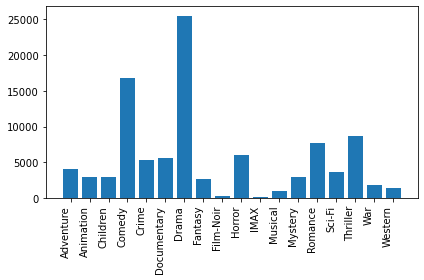

In [72]:
# plotting genre popularity
x={}
print("Genre       Number of Movies")
for i in movies_data.columns[4:23]:
    x[i[6:]]=movies_data[i].sum()
    print(f"{i[6:]:<15}{x[i[6:]]:>10}")


plt.bar(height=x.values(),x=x.keys())
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig('genre_count.png')
plt.show()


Drama is the most popular genre with 25,523 movies, followed by Comedy with 16,823 movies.

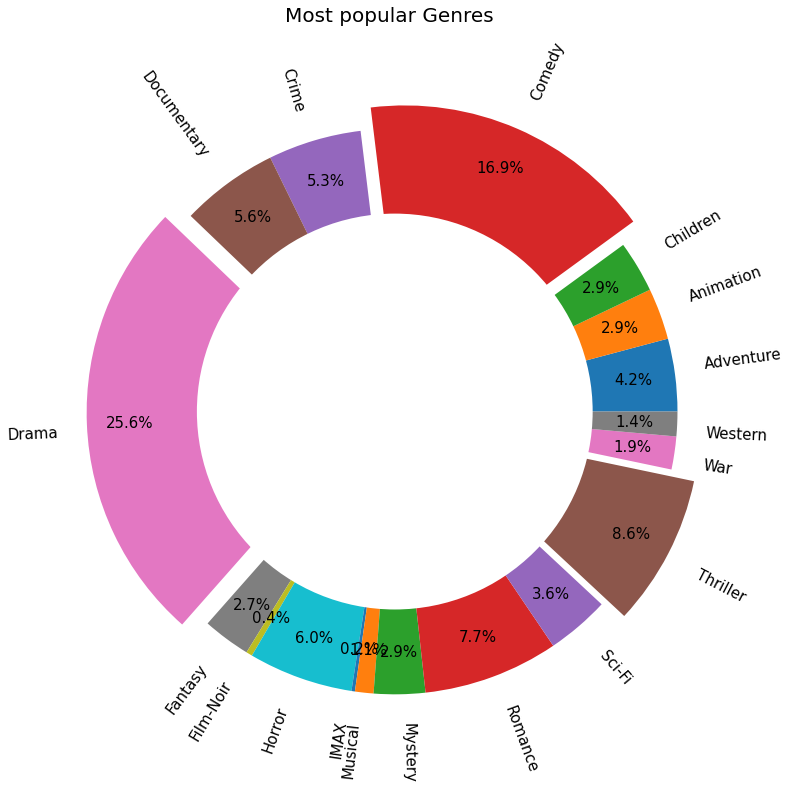

In [90]:
plt.figure(figsize=(12,12))

plt.pie(x=x.values(),
        labels=x.keys(), 
        explode=[0, 0, 0, 0.09, 0, 0, 0.09, 0, 0, 0, 0, 0, 0, 0, 0, 0.09, 0, 0], 
        textprops={'fontsize':15}, 
        autopct='%.1f%%',
        rotatelabels = True,
        pctdistance=0.85, 
       )


plt.gca().add_artist(plt.Circle((0,0) , 0.7 , fc = 'white'))

plt.title('Most popular Genres', pad = 50, fontsize=20)
plt.axis('equal')
plt.show()

We will now merge the ratings and movie dataframe to get the average rating and num of ratings per movie. 

In [91]:
# movies with no ratings receive 0 as their average rating
mean_rating = ratings_data.groupby('movieId').rating.mean().rename('mean rating')
num_rating = ratings_data.groupby('movieId').userId.count().rename('num rating')

movies_data = pd.merge(movies_data,mean_rating,how='left',on='movieId')
movies_data = pd.merge(movies_data,num_rating,how='left',on='movieId')

movies_data['mean rating'].fillna(0,inplace=True)
movies_data['num rating'].fillna(0,inplace=True)


movies_data[['title','mean rating', 'num rating']]

,title,mean rating,num rating
0,Toy Story (1995),3.893708,57309.0
1,Jumanji (1995),3.251527,24228.0
2,Grumpier Old Men (1995),3.142028,11804.0
3,Waiting to Exhale (1995),2.853547,2523.0
4,Father of the Bride Part II (1995),3.058434,11714.0
...,...,...,...
57124,Santosh Subramaniam (2008),5.000000,1.0
57125,We (2018),1.500000,1.0
57126,Window of the Soul (2001),3.000000,1.0
57127,Bad Poems (2018),4.500000,1.0


`mean rating` and `num rating` columns provide us information about the popularity of a movie. This information will play a key role in a paticular kind of recommendation system that we will see in the following section.

## Popularity-based Recommendation Engine

Probably the simplest and the most well used, popularity based recommendation systems recommend content/product based on trends in the overall database. 

While this system does not tailor recommendations to a particular user, it provides a good solution to deal with the cold-start problem.

For example, a model can recommend the top 10 most popular movies (movies with most number of ratings) in our database to a new user. 

In [98]:
movie_ratings = movies_data[['title','mean rating','num rating']]

In [99]:
movie_ratings.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
351,Forrest Gump (1994),4.048011,81491.0
314,"Shawshank Redemption, The (1994)",4.413576,81482.0
292,Pulp Fiction (1994),4.188912,79672.0
585,"Silence of the Lambs, The (1991)",4.151342,74127.0
2480,"Matrix, The (1999)",4.154099,72674.0
257,Star Wars: Episode IV - A New Hope (1977),4.120189,68717.0
475,Jurassic Park (1993),3.679175,64144.0
522,Schindler's List (1993),4.247579,60411.0
108,Braveheart (1995),4.002273,59184.0
2867,Fight Club (1999),4.228311,58773.0


As expected, all listed movies are internationally acclaimed hollywood classics. We can add more filters like that we want movies that were released after 2014. 

In [100]:
movie_ratings = movies_data[['title','year','mean rating','num rating']]
movie_ratings = movie_ratings[movie_ratings['year']>2014]
movie_ratings.sort_values(by=['num rating'], ascending=False).head(10)

,title,year,mean rating,num rating
28831,The Martian (2015),2015,4.033416,16489.0
24989,Deadpool (2016),2016,3.852662,13900.0
29097,Inside Out (2015),2015,3.932401,13580.0
24981,Mad Max: Fury Road (2015),2015,3.855034,13479.0
24983,Star Wars: Episode VII - The Force Awakens (2015),2015,3.739115,12678.0
22573,Ex Machina (2015),2015,3.969355,12547.0
39636,Arrival (2016),2016,4.027511,10087.0
23692,Kingsman: The Secret Service (2015),2015,3.798285,9620.0
35179,Zootopia (2016),2016,3.893646,8688.0
24985,Avengers: Age of Ultron (2015),2015,3.561780,7721.0


Now let's look at the top movies with the highest ratings in our database. 

In [101]:
movie_ratings = movies_data[['title','mean rating','num rating']]
movie_ratings.sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
32942,Million Dollar Crocodile (2012),5.0,1.0
48515,Richard Peter Johnson (2015),5.0,1.0
41665,Brad Williams: Daddy Issues (2016),5.0,1.0
44391,Cedric the Entertainer: Taking You Higher (2006),5.0,1.0
37678,In Her Line of Fire (2006),5.0,1.0
37677,One Way Out (2002),5.0,1.0
35363,Tammy and the Doctor (1963),5.0,1.0
41763,Trevor Moore: High In Church (2015),5.0,1.0
35392,Balls to the Wall (2011),5.0,1.0
55225,ReMoved (2013),5.0,2.0


While these movies are rated quite high, they are not popular and only have 1 rating. This is not reliable information. We need to set a threshold of the minimum number of ratings a movie must have. 

In [102]:
minimum_num_ratings = 500
movie_ratings[movie_ratings['num rating']>minimum_num_ratings].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
42362,Planet Earth II (2016),4.483096,1124.0
37945,Planet Earth (2006),4.464797,1747.0
314,"Shawshank Redemption, The (1994)",4.413576,81482.0
42236,Band of Brothers (2001),4.398599,1356.0
840,"Godfather, The (1972)",4.324336,52498.0
45734,Blue Planet II (2017),4.289833,659.0
49,"Usual Suspects, The (1995)",4.284353,55366.0
1190,"Godfather: Part II, The (1974)",4.261759,34188.0
39483,Over the Garden Wall (2013),4.258242,546.0
1930,Seven Samurai (Shichinin no samurai) (1954),4.254769,13367.0


These recommendations seem a lot more robust now. These movies are both popular and well loved. Interestingly the top 2 movies are documentaries.

Let's look at the what the tags look like for these "top 10 movies":

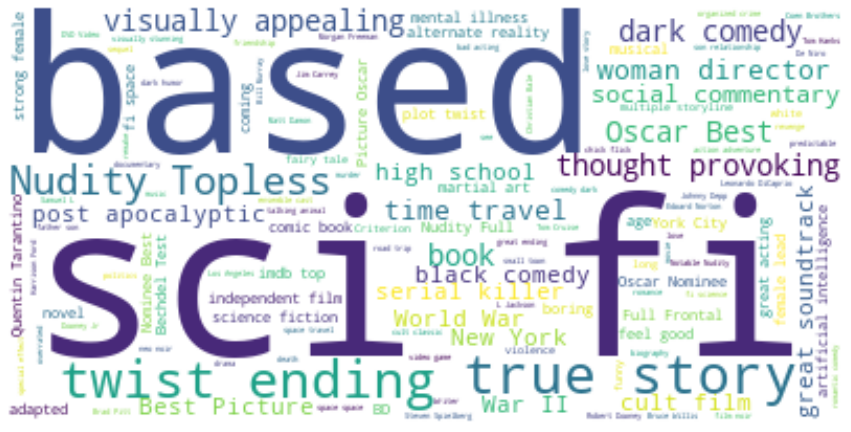

In [110]:
movie_ratings = movies_data[['movieId','title','mean rating','num rating']]

top_10_ids = movie_ratings[movie_ratings['num rating']>minimum_num_ratings].sort_values(by=['mean rating'], ascending=False).head(10).movieId.values
top_10_tags = tags_data[tags_data['movieId'].isin(top_10_ids)]

tags = " ".join(i for i in top_10_tags.tag)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(all_tags)

# Display the generated image:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let's also look at the 10 worst movies, movies that we won't recommend at all according to the popularity recommendation engine. These will be movies that are well hated.

In [111]:
minimum_num_ratings = 500
movie_ratings[movie_ratings['num rating']>minimum_num_ratings].sort_values(by=['mean rating'], ascending=False).tail(10)

,movieId,title,mean rating,num rating
12100,57532,Meet the Spartans (2008),1.609551,890.0
1671,1739,3 Ninjas: High Noon On Mega Mountain (1998),1.604553,593.0
3494,3593,Battlefield Earth (2000),1.578374,4268.0
9548,31424,Alone in the Dark (2005),1.506944,504.0
11350,50798,Epic Movie (2007),1.457203,1180.0
1447,1495,Turbo: A Power Rangers Movie (1997),1.423077,689.0
9604,31698,Son of the Mask (2005),1.232227,633.0
6464,6587,Gigli (2003),1.214380,758.0
12617,61348,Disaster Movie (2008),1.205566,557.0
4669,4775,Glitter (2001),1.125561,669.0


Many parody movies make this list. I feel that the users in MovieLens website might be film critics rather than the average population.

Let's look at what the tags look like for these.

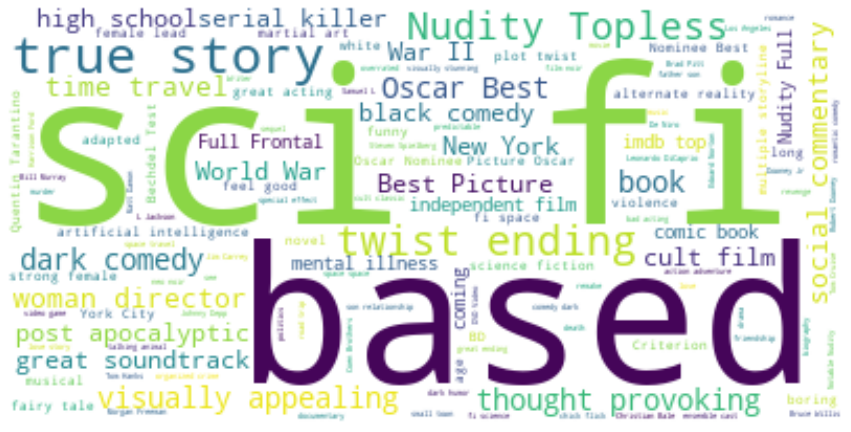

In [117]:
worst_10_ids = movie_ratings[movie_ratings['num rating']>minimum_num_ratings].sort_values(by=['mean rating'], ascending=False).tail(10).movieId.values
worst_10_tags = tags_data[tags_data['movieId'].isin(worst_10_ids)]

tags = " ".join(i for i in worst_10_tags.tag)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(all_tags)

# Display the generated image:
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Surprisingly these don't look drastically different the ones that we saw for the top movies, so maybe tags are very noisy and don't contain a lot of information after all.

Genre can also be used for further finetuning. While eventually we would want to understand a user's preferred genre by building a taste profile, currently we will allow the user to make a selection.  

So let's say there is a user who wants recommendation for an action movie, then:

In [125]:
user_genre = 'genre_Action'
minimum_num_ratings = 200
movie_ratings[(movies_data[user_genre] == 1) & (movies_data['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

,movieId,title,mean rating,num rating
42236,170705,Band of Brothers (2001),4.398599,1356.0
1930,2019,Seven Samurai (Shichinin no samurai) (1954),4.254769,13367.0
2867,2959,Fight Club (1999),4.228311,58773.0
887,908,North by Northwest (1959),4.196617,16850.0
5904,6016,City of God (Cidade de Deus) (2002),4.181587,19894.0
2937,3030,Yojimbo (1961),4.179179,3996.0
12220,58559,"Dark Knight, The (2008)",4.166538,41519.0
14933,79132,Inception (2010),4.155508,38895.0
2480,2571,"Matrix, The (1999)",4.154099,72674.0
1166,1196,Star Wars: Episode V - The Empire Strikes Back...,4.144122,57361.0


Whatever we have seen so far can be combined together to build a very simple popularity based recommendation engine. Here we will allow the user to set different filters like minimum number of ratings and genre.

In [136]:
from ipywidgets import HBox, VBox, IntSlider, interactive_output
from IPython.display import display

genres = ['All',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir'
         ]

popularity= widgets.IntSlider(min=0, max=3000, value=500, step=25)
fav_genre=widgets.Dropdown(options=genres, description="Genre")

def popularity_based_recommendation(popularity,fav_genre):
    
    if fav_genre == 'All':
        result = movie_ratings[(movies_data['num rating']>popularity)].sort_values(by=['mean rating'], ascending=False).head(10)    
    else:
        result = movie_ratings[(movies_data['genre_'+fav_genre] == 1) & (movies_data['num rating']>popularity)].sort_values(by=['mean rating'], ascending=False).head(10)
    
    print('\n\nThese are the recommendations for the users with the following filters')
    print('Minimum number of ratings:',popularity)
    print("User's choice of genre:",fav_genre,"\n")
    print(result)

    

w = interactive_output(popularity_based_recommendation, {"popularity":popularity,
                                                         "fav_genre":fav_genre}
               )
display(VBox([HBox([popularity,fav_genre]),w]))


## Collaborative Filtering

### Item based Using Correlation

We will now design a recommendation engine that uses the correlation between the ratings assigned to different movies, in order to find the similarity between the movies.

Let's create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie. 

In [ ]:
df = pd.merge(ratings_df,movies_df,how='left',on = 'movieId')
movie_user_matrix = df.pivot_table(index='userId',columns='title',values='rating')
movie_user_matrix

As most users will only review a few movies, majority of the values in this matrix will be NaN. 

Now, let's consider that you wish to look at movies that are similar to Lion King.

In [ ]:
movie_name = "Lion King, The (1994)"
movie_ratings_df = movie_user_matrix[movie_name]
movie_ratings_df.head()

Retrieving movies where the ratings are extremely correlated with Lion King:

In [ ]:
correlation = movie_user_matrix.corrwith(movie_ratings_df)
similar_movies = pd.DataFrame(correlation, columns=['Correlation'])

# removing nulls
similar_movies.dropna(inplace=True)

# Top 10 highly correlated movies with Lion King
similar_movies.sort_values('Correlation', ascending=False).head(10)

Some of these ratings make sense, but some don't. Let's bring number of ratings in picture here. We will set a threshold of 50 to the number of ratings here:

In [ ]:
similar_movies =  pd.merge(similar_movies, movies_df[['title','num rating']].drop_duplicates(), left_index=True, right_on='title')
similar_movies.set_index('title', inplace=True)

# Top 10 highly correlated movies with Lion King that have been rated more than 50 times
threshold = 50
similar_movies.sort_values('Correlation', ascending=False)[similar_movies['num rating']>threshold].head(10)

While there are some movies like Aladdin that do make sense here, most don't. This means that maybe we need to improve our model or add more information to help the model. 

## User based Collaborative Filtering using surprise library

For our next few models, we will utilize the `surprise` library which allows us to build complex recommendation engine pipelines  effortlessly. We will try out a total of five algorithms.

First three are KNN based algorithms:
- `KNNBasic`
- `KNNWithMeans`
- `KNNWithZScore`

Next two are matrix factorization based algorithms:
- `SVD`
- `SVDpp`

We will evaluate top models from each list and then do grid search on them to search for the best hyperparameters.

But first, we will convert our dataset into something that the surprise library can understand.

In [ ]:
# read in values as Surprise dataset 
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df,reader)

# generating a trainset
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

In [ ]:
# knn algorithms
cv_knn_basic = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_means = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_z = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
# matrix factorization algorithms
cv_svd = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)
cv_svd_pp = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=True)

In [ ]:
# Printing out the results for these algorithms
print('Evaluation Results:')
print('Algorithm\t RMSE\t\t MAE')

print()
print(f'KNN Basic \t {(cv_knn_basic["test_rmse"].mean()):.4f} \t {(cv_knn_basic["test_mae"].mean()):.4f}')
print(f'KNN Means \t {(cv_knn_means["test_rmse"].mean()):.4f} \t {(cv_knn_means["test_mae"].mean()):.4f}')
print(f'KNN ZScore \t {(cv_knn_z["test_rmse"].mean()):.4f} \t {(cv_knn_z["test_mae"].mean()):.4f}')

print()
print(f'SVD \t\t {(cv_svd["test_rmse"].mean()):.4f} \t {(cv_svd["test_mae"].mean()):.4f}')
print(f'SVDpp \t\t {(cv_svd_pp["test_rmse"].mean()):.4f} \t {(cv_svd_pp["test_mae"].mean()):.4f}')


We chose two standard errors as our evaluation metrics: 
* **Mean Absolute Error (MAE)** computes the average of all the the absolute value differences between the true and the predicted rating.
* **Root Mean Square Error (RMSE)** computes the mean value of all the differences squared between the true and the predicted ratings and then proceeds to calculate the square root out of the result. 

For both of these metrics, lower the error better the accuracy.

An avergae MAE of 0.6713 for SVD indicates an average absolute error of 0.6713 between the true and predicted ratings. We will try to reduce this error further by tuning hyperparameters.

In [ ]:
# Plotting graphs for comparing accuracy of each algo
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp',]
all_algos_cv = [cv_knn_basic, cv_knn_means, cv_knn_z, cv_svd, cv_svd_pp]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

# RMSE graph
plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

# MAE graph
plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


Both the Matrix Factorization algorithms seem to do much better for both the metrics. KNN Means and KNN ZScore are also okay as compared to KNN Basic.

Selecting top models from each algorithm type: **KNN Means** and **SVDpp** 

### KNN based algorithms

We will now optimize on these two models. Let's start with KNN Means. We will optimize two hyperparameters: `k(number of neighbors)` and `distance metric`. First, we search for optimal `k` between 5 and 100.

In [ ]:
param_grid = {'k': [5, 10, 15, 20, 25, 30, 40, 50, 60,70,80,90,100]}

gs_knn_means = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_knn_means.fit(data)

y1 = gs_knn_means.cv_results['mean_test_rmse']
y2 = gs_knn_means.cv_results['mean_test_mae']

In [ ]:
# plotting accuracies for comparison
plt.figure(figsize=(18,5))

x = [5,10, 15, 20, 25, 30, 40, 50, 60,70,80,90,100]

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNWithMeans', color='lightcoral', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNWithMeans', color='lightcoral', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()


From the plots above, pptimal `k` is found at 20. Now, we will look for the best distance metric out of these four: `cosine`, `pearson`, `msd`, and `pearson baseline`.

In [ ]:
# comparing distance metrics

knn_means_cosine = cross_validate(KNNWithMeans(k=20, sim_options={'name':'cosine'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_pearson = cross_validate(KNNWithMeans(k=20, sim_options={'name':'pearson'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_msd = cross_validate(KNNWithMeans(k=20, sim_options={'name':'msd'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_pearson_baseline = cross_validate(KNNWithMeans(k=20, sim_options={'name':'pearson_baseline'}), data, cv=5, n_jobs=5, verbose=True)

x_distance = ['cosine', 'pearson', 'msd', 'pearson_baseline',]
all_distances_cv = [knn_means_cosine, knn_means_pearson, knn_means_msd, knn_means_pearson_baseline]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_distances_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_distances_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Distance Metrics on RMSE', loc='center', fontsize=15)
plt.plot(x_distance, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Distance Metrics', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Distance Metrics on MAE', loc='center', fontsize=15)
plt.plot(x_distance, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Distance Metrics', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()


Based on our hyperparameter tuning, the best KNN based model that we found out was:

KNN-Means with k=20 and pearson_baseline similarity

**RMSE:** 0.8984  
**MAE:** 0.6807

### Matrix factorization based algorithms

While SVDpp had the better performance in terms of error rate, it is very time consuming to train. A grid search on SVDpp lasts many days. So, I chose to optimize the SVD model for number of epochs, learning rate and regularization using grid search.

In [ ]:
# Parameter space

svd_param_grid = {'n_epochs': [20, 25,30,40,50], 
                  'lr_all': [0.007, 0.009, 0.01,0.02],
                  'reg_all': [0.02, 0.04, 0.1, 0.2]}

# This will take some time to execute.
gs_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_svd.fit(data)
print('Best value for SVD   - RMSE:', round(gs_svd.best_score['rmse'], 4), '; MAE:', round(gs_svd.best_score['mae'], 4))
print('Optimal params RMSE =', gs_svd.best_params['rmse'])
print('Optimal params MAE =', gs_svd.best_params['mae'])

Based on our hyperparameter tuning, the best Matrix factorization based model that we found out was:

SVD with number of epochs = 50, learning rate = 0.02, and regularization = 0.1 

**RMSE:** 0.8507  
**MAE:** 0.6517

### Predictions

Let's see the model in action to check if it's working as expected or not. But, first we need to fit both the final models on a training set. 

In [ ]:
dataset = data.build_full_trainset()
final_knn_model = KNNWithMeans(k=20, sim_options={'name':'pearson_baseline'})
final_knn_model.fit(dataset)

In [ ]:
final_svd_model = SVD(n_epochs=50, lr_all=0.02, reg_all=0.1)
final_svd_model.fit(dataset)

Now that we have a trained model, we can use it to predict the rating a user would assign to a movie given an ID for the user (UID) and an ID for the item/movie (IID). 

We are picking user with `userId`=610. This user really liked the movie `Toy Story (1995)`. We will now try to predict the rating that this user will give to the movie `Toy Story 3 (2010)`. 

In [ ]:
# Showing rating given by this user for Toy Story (1995)
# userId: 610
# movieId: 1 for Toy Story (1995)
df[(df['userId']==610) & (df['movieId']==1)][['userId','movieId','rating','title']]

Toy Story 3 (2010) was a well loved movie. We would assume that a user who really liked Toy Story 1 would really this movie. So, we hope that the expected rating given by each of these models is quite high. 

In [ ]:
# KNN Model prediction on iid: 78499 - Toy Story 3 (2010)
final_knn_model.predict(uid=610, iid=78499)

In [ ]:
# SVD Model prediction on iid: 78499 - Toy Story 3 (2010)
final_svd_model.predict(uid=610, iid=78499)

The field `est` indicates the estimated movie rating for this specific user.

We see that both the models give a strong positive rating for this specifiv movie and user. We also ran random experiments with a couple dozen user-movie pairs and received results that are consistent with our expectation. 

We choose to move forward with the SVD model as it has a lower MAE and RMSE value. 

We will now design a generic function which will take in a user id, then calculate expected ratings for all the movies and return the top 5 movies with the highest expected ratings. 

We will also filter out movies already viewed by the user and provide functionality to mention preferred genre and minimum number of ratings. 


In [ ]:
def get_movie_recommendations(user_id, preferred_genre = 'all',minimum_num_ratings=50):
    
    new_df = df.copy()
    
    # filtering out by genre
    if preferred_genre !='all':
        new_df = new_df[new_df[preferred_genre]==1]
    
    # filtering out by number of ratings
    new_df = new_df[new_df['num rating']>=minimum_num_ratings]
    
    # filtering out all movies already rated by user
    movies_already_watched = set(new_df[new_df['userId']==user_id].movieId.values)
    new_df= new_df[~new_df['movieId'].isin(movies_already_watched)]
    
    # finding expected ratings for all remaining movies in the dataset
    all_movie_ids = set(new_df['movieId'].values)
    all_movie_ratings = []
    
    for i in all_movie_ids:
        expected_rating = final_svd_model.predict(uid=user_id, iid=i).est
        all_movie_ratings.append((i,round(expected_rating,1)))
        
    # extracting top five movies by expected rating
    expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
    result_df = pd.merge(expected_df, movies_df[['movieId','title','num rating']],on='movieId')
    result_df = result_df.sort_values(['Expected Rating','num rating'],ascending=[False,False])
    
    return result_df.head()

In [ ]:
# receiving movie ratings for a given user id
get_movie_recommendations(1)

Everything seems to be in place now. The above function utilizes both the model plus some filters to give some truly amazing movie recommendations. 

Minimum number of ratings is an interesting filter because if we set it too high, we only get classics and we won't find any new movies. Whereas if we set it too low, we can get virtually any movie. We like to think of it as an exploration risk parameter. Set value for it by asking yourself the following question: **How much risk are you willing to take to find new movies?**

## Final Recommendation Engine

The final recommendation engine will be a hybrid between two models that we saw in this file: the final SVD model and the naive recommendation engine. 

1. The naive recommendation engine is used to solve the **cold-start** problem for users who are new and have no ratings in the dataset.
2. If the userId is in the dataset, then we will use the final model with filters that we saw in the previous section.

In [ ]:
def hybrid_recommendation_engine(user_id='new',preferred_genre='all',minimum_num_ratings=50):
    
    if user_id=='new':
        if preferred_genre == 'all':
            result = movie_ratings[(movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)    
        else:
            result = movie_ratings[(movies_df[preferred_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

    else:
        new_df = df.copy()
    
        # filtering out by genre
        if preferred_genre !='all':
            new_df = new_df[new_df[preferred_genre]==1]

        # filtering out by number of ratings
        new_df = new_df[new_df['num rating']>=minimum_num_ratings]

        # filtering out all movies already rated by user
        movies_already_watched = set(new_df[new_df['userId']==user_id].movieId.values)
        new_df= new_df[~new_df['movieId'].isin(movies_already_watched)]

        # finding expected ratings for all remaining movies in the dataset
        all_movie_ids = set(new_df['movieId'].values)
        all_movie_ratings = []

        for i in all_movie_ids:
            expected_rating = final_svd_model.predict(uid=user_id, iid=i).est
            all_movie_ratings.append((i,round(expected_rating,1)))

        # extracting top five movies by expected rating
        expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
        result = pd.merge(expected_df, movies_df[['movieId','title','num rating']],on='movieId')
        result = result.sort_values(['Expected Rating','num rating'],ascending=[False,False])
        result = result.head()
    
    
    print('\n\nThese are the recommendations for the users with the following filters')
    print('User id:',user_id)
    print('Minimum number of ratings:',minimum_num_ratings)
    print("User's choice of genre:", preferred_genre)
    display(result)


        
genres = ['all',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir'
         ]
all_userids = ['new'] + list(set(df.userId.values))
w = interactive(hybrid_recommendation_engine,
                user_id=widgets.Dropdown(options=all_userids, description="user_id"),
                minimum_num_ratings=widgets.IntSlider(min=0, max=200, value=100, step=5),
                preferred_genre=widgets.Dropdown(options=genres, description="Genre")
               )
display(w)


The hybrid recommendation engine allows us to effectively solve the cold-start problem and provide meaningful movie recommendations to all users. 

Kindly try out the dashboard and let us know what you think. We have been using this for movie night recommendations. 

## Conclusion

We analyzed a variety of movie recommendation systems on the famous MovieLens database. We started with a naive recommendation engine which did not make any assumptions about the user and provided general recommendations based upon movie popularity or the average ratings given by other users in the database. 

We then progressed to some collaborative filtering based engines which try to find similar movies or users to make their predictions. After assessing models on two metrics, `RMSE` and `MAE`, we designed a `SVD` model and also tuned it for multiple hyperparameters. 

Finally, we made a hybrid system of our naive recommendation engine and the `SVD` model to help resolve the cold-start problem. We added filtering options for genre and minimum number of ratings to give users some control over these recommendations. 

# Future Work

There is a lot of potential for future work in this project. 

To begin with, we would like to add functionality in our final dashboard to allow new users to rate some movies and then to utilize that information to improve our recommendation system. 

We also couldn't make use of `tag` information in this part of the analysis. We would like to make word embeddings from tags and other meta information about the movie and use it in our model. 

We can also make use of the `links` dataset and scrape more information about each movie from the internet. This could involve significant features like cast, director, plot, etc. 